<p style="color: darkred; font-size: 50px; text-align: center;"><b>Time Series Analysis</b></p>
<p style="color: darkred; font-size: 30px; text-align: center;">Labs #3. ADF and alternatives</p>
<p style="font-size: 20px; text-align: center;">Paweł Sakowski, Maciej Świtała</p>
<p style="font-size: 20px; text-align: center;">Spring 2025</p>
<p align="center">
  <img src="img/wne-logo-new-en.jpg" width="498" height="107">
</p>

### Libraries

First, let's load to memory libraries that will be used today. If neccesary, you may first install them.

In [271]:
#!pip install pandas matplotlib yfinance statsmodels arch
#!pip install --upgrade yfinance

In [362]:
import pandas as pd # for data manipulation

import numpy as np # for calculations

import matplotlib.pyplot as plt # for vizualization
import matplotlib.dates as mdates # for data formatting when visualizing
import matplotlib.ticker as ticker # for more advanced axis formatting

import seaborn as sns # for more advanced / alternative vizualization

import yfinance as yf # for importing data directly from finance.yahoo.com

import scipy.stats as stats # for specific distributions to be accessed

import statsmodels.api as sm # for linear regression model, OLS estimation
import statsmodels.stats.diagnostic as smd # for Breusch-Godfrey test

from statsmodels.tsa.stattools import adfuller # for performing ADF test
from arch.unitroot import ADF # for performing ADF test
from arch.unitroot import PhillipsPerron # for performing PP test
from statsmodels.tsa.stattools import kpss # for performing KPSS test

import warnings
warnings.simplefilter(action="ignore", category=UserWarning)  # ignores all UserWarnings

### 1. Loading the data

Today we will work with the SP500 daily quotations. Let’s import the data from Yahoo! Finance services. The symbol is `^GSPC`.

In [273]:
SP500 = yf.download("^GSPC", start="2015-01-01", end="2024-12-31")

[*********************100%***********************]  1 of 1 completed


In [274]:
SP500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   2515 non-null   float64
 1   (High, ^GSPC)    2515 non-null   float64
 2   (Low, ^GSPC)     2515 non-null   float64
 3   (Open, ^GSPC)    2515 non-null   float64
 4   (Volume, ^GSPC)  2515 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


In [275]:
SP500.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000


In [277]:
SP500.tail()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2024-12-23,5974.069824,5978.250000,5902.569824,5940.250000,3593280000
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000
2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2904530000
2024-12-27,5970.839844,6006.169922,5932.950195,6006.169922,3159610000
2024-12-30,5906.939941,5940.790039,5869.160156,5920.669922,3433250000


Let us consider the close prices, visualize them and their differences.

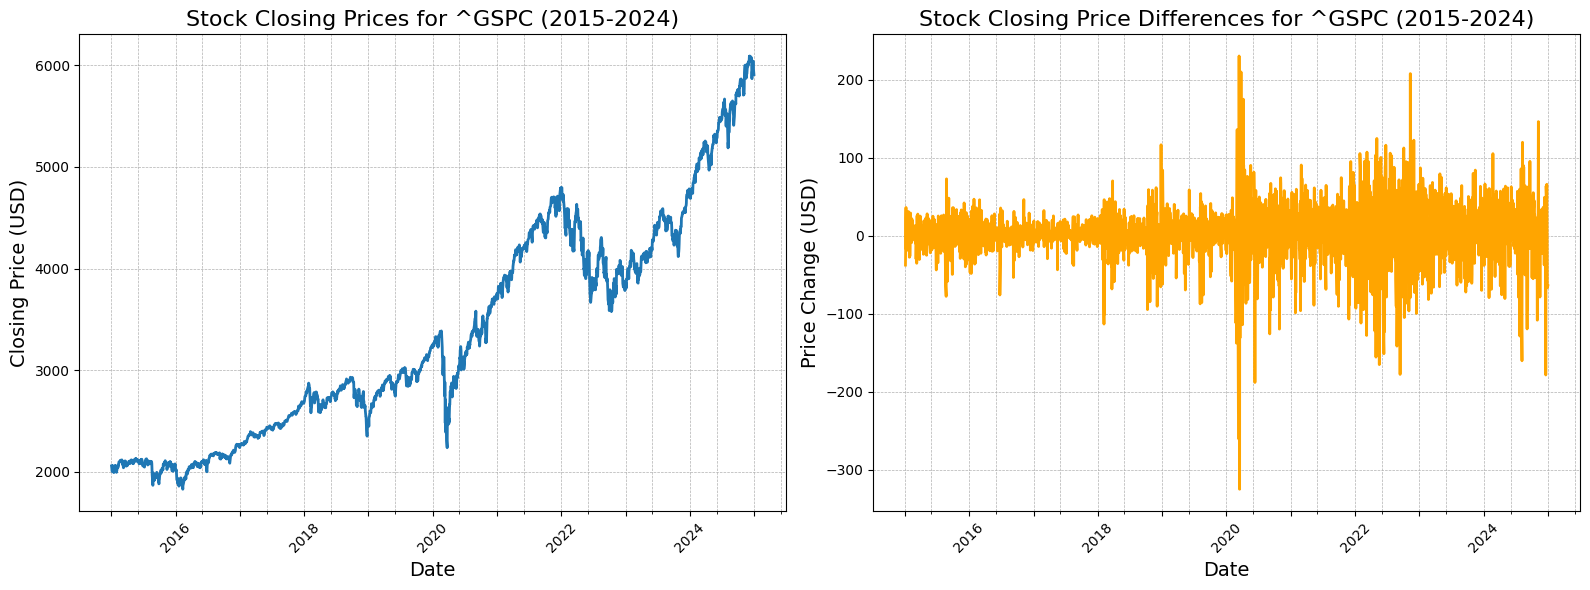

In [278]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

# --- FIRST PLOT: Closing Prices ---
axes[0].plot(SP500.index, SP500["Close"]["^GSPC"], linewidth=2)
axes[0].set_title("Stock Closing Prices for ^GSPC (2015-2024)", fontsize=16)
axes[0].set_xlabel('Date', fontsize=14)
axes[0].set_ylabel('Closing Price (USD)', fontsize=14)

# Formatting X-axis
axes[0].xaxis.set_major_locator(mdates.YearLocator(1))  # Major ticks every year
axes[0].xaxis.set_minor_locator(mdates.MonthLocator(6))  # Minor ticks every 6 months
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: str(int(mdates.num2date(x).year)) if int(mdates.num2date(x).year) % 2 == 0 else ""))
axes[0].tick_params(axis='x', rotation=45)  # Rotate labels for readability
axes[0].grid(visible=True, which='both', linestyle='--', linewidth=0.5)  # Add grid

# --- SECOND PLOT: First Differences ---
SP500_diff = SP500["Close"]["^GSPC"].diff()  # Compute first differences

axes[1].plot(SP500.index, SP500_diff, linewidth=2, color='orange')
axes[1].set_title("Stock Closing Price Differences for ^GSPC (2015-2024)", fontsize=16)
axes[1].set_xlabel('Date', fontsize=14)
axes[1].set_ylabel('Price Change (USD)', fontsize=14)

# Formatting X-axis
axes[1].xaxis.set_major_locator(mdates.YearLocator(1))
axes[1].xaxis.set_minor_locator(mdates.MonthLocator(6))
axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: str(int(mdates.num2date(x).year)) if int(mdates.num2date(x).year) % 2 == 0 else ""))
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(visible=True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

Based on visual inspection of the data we can say that the time series seems to be non-stationary, while its first differences can be suspected for stationarity.

### 2. (Augmented) Dickey-Fuller test

### 2.1. Dickey-Fuller (DF) test (no augmentations)

Were we to consider testing stationarity of a sereis $y_t$, one should estimate the following equation:

$$\Delta y_t = \delta y_{t-1} + \epsilon_t$$

The idea behind it is that for $y_t = \gamma y_{t-1} + \epsilon_t$, $\gamma=1$ would mean a random walk that is by definition non-stationary (as it includes a stochastic trend, i.e., its variance does depend on time). In contrary, $\gamma=0$ would mean that $y_t$ is a white noise, by its definition a specific example of a stationary series. Therefore, to conclude about stationarity of $y_t$, one should test whether $\gamma=0$. 

Still, if indeed $y_t$ is non-stationary, there is a risk of obtaining spurious results from $y_t = \gamma y_{t-1} + \epsilon_t$ estimation. Therefore, it is transformed into $\Delta y_t = \delta y_{t-1} + \epsilon_t$, as $\gamma = \delta + 1$ substitution is introduced, i.e., $y_t = (\delta + 1) y_{t-1} + \epsilon_t$, which makes $y_t = \delta y_{t-1} + y_{t-1} + \epsilon_t$, and consequently $y_t - y_{t-1} = \delta y_{t-1} + \epsilon_t$.

As a result, it is tested whether $\delta = 0$, which implies $\gamma = 1$, i.e., non-stationarity.

**CAUTION: conclusion on $H_0: \delta=0$ is possible only if the residuals $e_t$, constituting a realization of $\epsilon_t$, are NOT autocorrelated!** Therefore, it is required to perform test for autocorrelation of residuals, e.g., with the Breusch-Godfrey, or Durbin-Watson tests.

In [279]:
series = SP500["Close"]["^GSPC"] # time series under consideration
model = sm.OLS(series.diff(), series.shift(), missing='drop').fit() # fitting a linear regression with OLS
model.summary() # model's summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  ^GSPC   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              4.225
Date:                Wed, 26 Feb 2025   Prob (F-statistic):                      0.0399
Time:                        14:16:04   Log-Likelihood:                         -12669.
No. Observations:                2514   AIC:                                  2.534e+04
Df Residuals:                    2513   BIC:                                  2.535e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
^GSPC          0.0004      0.000      2.055      0.040       2e-05       0.001
==============================================================================
Omnibus:                      527.086   Durbin-Watson:                   2.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5963.641
Skew:                          -0.656   Prob(JB):                         0.00
Kurtosis:                      10.430   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**These results can be interpreted if the residuals are not autocorrelated**. Let us test this with Breusch-Godfrey test. The null hypothesis states that the residuals are not autocorrelated. The empirics recommend trying different numbers of lags in this test.

In [280]:
bg_test = smd.acorr_breusch_godfrey(model, nlags=5)

print(f"Test statistic: {round(bg_test[0],2)}")
print(f"P-value: {round(bg_test[1],4)}")

Test statistic: 24.34
P-value: 0.0002


In [281]:
bg_test = smd.acorr_breusch_godfrey(model, nlags=10)

print(f"Test statistic: {round(bg_test[0],2)}")
print(f"P-value: {round(bg_test[1],4)}")

Test statistic: 98.25
P-value: 0.0


In [282]:
bg_test = smd.acorr_breusch_godfrey(model, nlags=15)

print(f"Test statistic: {round(bg_test[0],2)}")
print(f"P-value: {round(bg_test[1],4)}")

Test statistic: 104.43
P-value: 0.0


**The residuals are autocorrelated** as the p-values are lower than the preassumed significance levels (0.01, 0.05, 0.1). We cannot interpret the estimates.

### 2.2. Augmented Dickey-Fuller (ADF) test (with augmentations)

**The problem of autocorrelation can be handled by adding augmentations**. An augmentation is an independent variable being the lagged dependent variable. Consequently, the ADF test formula with one augmentation is:

$$\Delta y_t = \delta y_{t-1} + \beta_1 \Delta y_{t-1} + \epsilon_t$$

Let us try estimating a model with one augmentation added.

In [283]:
series = SP500["Close"]["^GSPC"] # time series under consideration

X = pd.DataFrame({'y_lag': series.shift(), 'y_diff_lag': series.diff().shift()})
model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS
model.summary() # model's summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  ^GSPC   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              9.865
Date:                Wed, 26 Feb 2025   Prob (F-statistic):                    5.40e-05
Time:                        14:16:20   Log-Likelihood:                         -12656.
No. Observations:                2513   AIC:                                  2.532e+04
Df Residuals:                    2511   BIC:                                  2.533e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y_lag          0.0005      0.000      2.278      0.023    6.69e-05       0.001
y_diff_lag    -0.0782      0.020     -3.928      0.000      -0.117      -0.039
==============================================================================
Omnibus:                      530.911   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5262.739
Skew:                          -0.706   Prob(JB):                         0.00
Kurtosis:                       9.947   Cond. No.                         94.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let us check if one augmentation is enough to obtain a model with non-autocorrelated residuals.

In [284]:
bg_test = smd.acorr_breusch_godfrey(model, nlags=5)

print(f"Test statistic: {round(bg_test[0],2)}")
print(f"P-value: {round(bg_test[1],4)}")

Test statistic: 9.13
P-value: 0.104


In [285]:
bg_test = smd.acorr_breusch_godfrey(model, nlags=10)

print(f"Test statistic: {round(bg_test[0],2)}")
print(f"P-value: {round(bg_test[1],4)}")

Test statistic: 83.58
P-value: 0.0


In [286]:
bg_test = smd.acorr_breusch_godfrey(model, nlags=15)

print(f"Test statistic: {round(bg_test[0],2)}")
print(f"P-value: {round(bg_test[1],4)}")

Test statistic: 90.47
P-value: 0.0


Assumming reasonable significance levels, **we still reject the null hypothesis assumming no autocorrelation** when considering 10 and 15 lags. Therefore, **we cannot interpret the results of the ADF test**. Let us try another augmentation.

In [287]:
series = SP500["Close"]["^GSPC"] # time series under consideration

X = pd.DataFrame({'y_lag': series.shift(), 'y_diff_lag1': series.diff().shift(1), 'y_diff_lag2': series.diff().shift(2)})
model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS
model.summary() # model's summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  ^GSPC   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              7.633
Date:                Wed, 26 Feb 2025   Prob (F-statistic):                    4.44e-05
Time:                        14:16:26   Log-Likelihood:                         -12650.
No. Observations:                2512   AIC:                                  2.531e+04
Df Residuals:                    2509   BIC:                                  2.532e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
y_lag           0.0005      0.000      2.181      0.029    4.66e-05       0.001
y_diff_lag1    -0.0757      0.020     -3.788      0.000      -0.115      -0.036
y_diff_lag2     0.0349      0.020      1.746      0.081      -0.004       0.074
==============================================================================
Omnibus:                      508.837   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5031.809
Skew:                          -0.664   Prob(JB):                         0.00
Kurtosis:                       9.805   Cond. No.                         98.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [288]:
bg_test = smd.acorr_breusch_godfrey(model, nlags=5)

print(f"Test statistic: {round(bg_test[0],2)}")
print(f"P-value: {round(bg_test[1],4)}")

Test statistic: 9.37
P-value: 0.0953


In [289]:
bg_test = smd.acorr_breusch_godfrey(model, nlags=10)

print(f"Test statistic: {round(bg_test[0],2)}")
print(f"P-value: {round(bg_test[1],4)}")

Test statistic: 80.9
P-value: 0.0


In [290]:
bg_test = smd.acorr_breusch_godfrey(model, nlags=15)

print(f"Test statistic: {round(bg_test[0],2)}")
print(f"P-value: {round(bg_test[1],4)}")

Test statistic: 88.42
P-value: 0.0


Still not enough to obtain non-autocorrelated residuals for different numbers of lags. Let us try to establish how many augmentations should be added until we get non-autocorrelated residuals.

In [294]:
series = SP500["Close"]["^GSPC"] # time series under consideration

X = pd.DataFrame({'y_lag': series.shift()})
y = series.diff()

max_aug = 25

results = []

for i in range(0, max_aug): # iterating through different numbers of augmentations
    
    for aug in range(1, i+1): # adding augmentations one by one until its current amount is reached
        X['aug_'+str(aug)] = y.shift(aug)

    model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

    bg_test5 = smd.acorr_breusch_godfrey(model, nlags=5); bg_pvalue5 = round(bg_test5[1],4)
    bg_test5 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test5[1],4)
    bg_test5 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test5[1],4)

    results.append([i, bg_pvalue5, bg_pvalue10, bg_pvalue15])

results_df = pd.DataFrame(results)
results_df.columns = ['number of augmentations', 'BG test (5 lags) (p-value)', 'BG test (10 lags) (p-value)', 'BG test (15 lags) (p-value)']
results_df

,number of augmentations,BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,0.0002,0.0000,0.0000
1,1,0.1040,0.0000,0.0000
2,2,0.0953,0.0000,0.0000
3,3,0.0028,0.0000,0.0000
4,4,0.0000,0.0000,0.0000
5,5,0.0000,0.0000,0.0000
6,6,0.0000,0.0000,0.0000
7,7,0.0000,0.0000,0.0000
8,8,0.0000,0.0003,0.0011
9,9,0.1564,0.2006,0.1772


It appears that autocorrelation, assumming a 5%-significance-level, is removed (for all versions of Breusch-Godfrey test, i.e., for different numbers of lags, tried) when adding **9 augmentations**. Notably, when keeping adding augmentations, the result start to blur, e.g., for 16 augmentations again not all the versions of the test indicate no autocorrelation. It demonstrates that **one should pick the number of augmentations that is enough to remove autocorrelation but no more than neccessary**.

Let us investigate the model with 9 augmentations as this is the first that can (and therefore should) be interpreted.

In [295]:
series = SP500["Close"]["^GSPC"] # time series under consideration

X = pd.DataFrame({'y_lag': series.shift()})
y = series.diff()

for aug in range(1, 10): # adding augmentations one by one until its optimal amount (9) is reached
    X['aug_'+str(aug)] = y.shift(aug)

model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  ^GSPC   R-squared (uncentered):                   0.039
Model:                            OLS   Adj. R-squared (uncentered):              0.035
Method:                 Least Squares   F-statistic:                              10.04
Date:                Wed, 26 Feb 2025   Prob (F-statistic):                    1.04e-16
Time:                        14:17:21   Log-Likelihood:                         -12579.
No. Observations:                2505   AIC:                                  2.518e+04
Df Residuals:                    2495   BIC:                                  2.524e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y_lag          0.0005      0.000      2.170      0.030    4.42e-05       0.001
aug_1         -0.0544      0.020     -2.728      0.006      -0.094      -0.015
aug_2          0.0195      0.020      0.978      0.328      -0.020       0.059
aug_3         -0.0112      0.020     -0.564      0.573      -0.050       0.028
aug_4         -0.0422      0.020     -2.123      0.034      -0.081      -0.003
aug_5          0.0061      0.020      0.309      0.758      -0.033       0.045
aug_6         -0.0604      0.020     -3.040      0.002      -0.099      -0.021
aug_7          0.0834      0.020      4.186      0.000       0.044       0.122
aug_8         -0.0677      0.020     -3.373      0.001      -0.107      -0.028
aug_9          0.0957      0.020      4.764      0.000       0.056       0.135
==============================================================================
Omnibus:                      472.956   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3369.532
Skew:                          -0.701   Prob(JB):                         0.00
Kurtosis:                       8.506   Cond. No.                         103.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [296]:
bg_test = smd.acorr_breusch_godfrey(model, nlags=5)

print(f"Test statistic: {round(bg_test[0],2)}")
print(f"P-value: {round(bg_test[1],4)}")

Test statistic: 8.0
P-value: 0.1564


In [297]:
bg_test = smd.acorr_breusch_godfrey(model, nlags=10)

print(f"Test statistic: {round(bg_test[0],2)}")
print(f"P-value: {round(bg_test[1],4)}")

Test statistic: 13.43
P-value: 0.2006


In [298]:
bg_test = smd.acorr_breusch_godfrey(model, nlags=15)

print(f"Test statistic: {round(bg_test[0],2)}")
print(f"P-value: {round(bg_test[1],4)}")

Test statistic: 19.86
P-value: 0.1772


We are interested in statistical significance of the estimate $\delta$. Yet, in ADF test, the test statistic does not have the Student's t distribution as it is usually in the OLS linear regression model. It has its own specific distribution that was established empirically. Therefore, to have any opportunity for concluding on (non-)stationarity of the series, we need to **take the test statistic of of the output and compare it with DF test's critical values**.

In [299]:
model.tvalues['y_lag'] # test statistic

2.1701407070533714

The critical values for the DF test are:

- for model with no constant, no trend:
<table>
    <thead>
        <tr>
            <th>Sample size</th>
            <th>99% Confidence interval</th>
            <th>95% Confidence interval</th>
            <th>90% Confidence interval</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>25</td>
            <td>-2.661</td>
            <td>-1.955</td>
            <td>-1.609</td>
        </tr>
        <tr>
            <td>50</td>
            <td>-2.612</td>
            <td>-1.947</td>
            <td>-1.612</td>
        </tr>
        <tr>
            <td>100</td>
            <td>-2.588</td>
            <td>-1.944</td>
            <td>-1.614</td>
        </tr>
        <tr>
            <td>250</td>
            <td>-2.575</td>
            <td>-1.942</td>
            <td>-1.616</td>
        </tr>
        <tr>
            <td>500</td>
            <td>-2.570</td>
            <td>-1.942</td>
            <td>-1.616</td>
        </tr>
        <tr>
            <td>>500</td>
            <td>-2.567</td>
            <td>-1.941</td>
            <td>-1.616</td>
        </tr>
    </tbody>
</table>

- for model with constant, no trend:
<table>
    <thead>
        <tr>
            <th>Sample size</th>
            <th>99% Confidence interval</th>
            <th>95% Confidence interval</th>
            <th>90% Confidence interval</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>25</td>
            <td>-3.724</td>
            <td>-2.986</td>
            <td>-2.633</td>
        </tr>
        <tr>
            <td>50</td>
            <td>-3.568</td>
            <td>-2.921</td>
            <td>-2.633</td>
        </tr>
        <tr>
            <td>100</td>
            <td>-3.498</td>
            <td>-2.891</td>
            <td>-2.582</td>
        </tr>
        <tr>
            <td>250</td>
            <td>-3.457</td>
            <td>-2.873</td>
            <td>-2.573</td>
        </tr>
        <tr>
            <td>500</td>
            <td>-3.443</td>
            <td>-2.867</td>
            <td>-2.570</td>
        </tr>
        <tr>
            <td>>500</td>
            <td>-3.434</td>
            <td>-2.863</td>
            <td>-2.568</td>
        </tr>
    </tbody>
</table>

- for model with constant, trend:
<table>
    <thead>
        <tr>
            <th>Sample size</th>
            <th>99% Confidence interval</th>
            <th>95% Confidence interval</th>
            <th>90% Confidence interval</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>25</td>
            <td>-4.375</td>
            <td>-3.589</td>
            <td>-3.238</td>
        </tr>
        <tr>
            <td>50</td>
            <td>-4.152</td>
            <td>-3.495</td>
            <td>-3.181</td>
        </tr>
        <tr>
            <td>100</td>
            <td>-4.052</td>
            <td>-3.452</td>
            <td>-3.153</td>
        </tr>
        <tr>
            <td>250</td>
            <td>-3.995</td>
            <td>-3.427</td>
            <td>-3.137</td>
        </tr>
        <tr>
            <td>500</td>
            <td>-3.977</td>
            <td>-3.419</td>
            <td>-3.132</td>
        </tr>
        <tr>
            <td>>500</td>
            <td>-3.963</td>
            <td>-3.413</td>
            <td>-3.128</td>
        </tr>
    </tbody>
</table>

We have 2505 observations (see the model's summary). We do not include a constant, nor a trend component. Therefore, we should compare the test statistic obtained with the very last row from the first table. Test statistic is positive, whereas it should be below -2.567, -1.941, -1.616 (for 1%, 5%, and 10% significance levels) to reject the null hypothesis of non-stationarity.

The series is **non-stationary**.

### 2.3. Distribution of DF test statistic

For educational purposes, let us demonstrate that the DF test statistic differs from any other well-established distiburions.

We will generate independetly 1000 random walks, then to be tested for stationarity, i.e., we will collect the t statistics for all iterations and plot them.

In [368]:
tStats = [] # to store t statistics fom DF test

nReps = 10000 # let us repeat this experiment 1000 times

for i in range(0, nReps):

    # Here, we generate a random walk (always non-stationary)
    y = np.zeros(1000)
    e = np.random.normal(0, 1, 1000)

    for i in range(1, nObs):
        y[i] = y[i - 1] + e[i]

    y = pd.Series(y) # we make it pandas.Series to use .shift() and .diff() operators

    # DF test performed
    X = pd.DataFrame({'y_lag': y.shift()})
    model = sm.OLS(y.diff(), X, missing='drop').fit()

    tStats.append(model.tvalues['y_lag'])

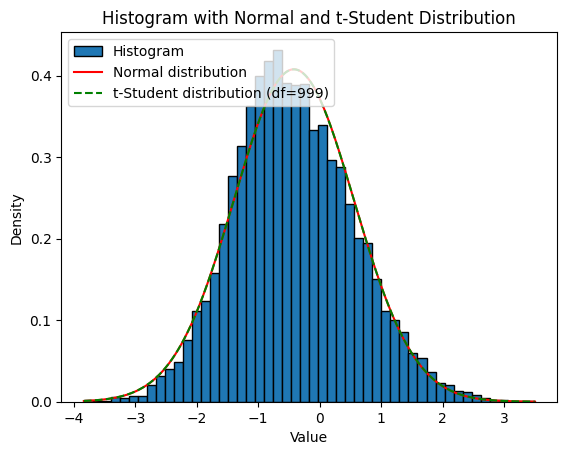

In [369]:
# Create histogram
plt.hist(tStats, bins=50, density=True, edgecolor='black', label='Histogram')

# Fit and plot normal distribution
mu, sigma = np.mean(tStats), np.std(tStats, ddof=1)
x = np.linspace(min(tStats), max(tStats), 1000)
pdf_normal = stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf_normal, 'r-', label='Normal distribution')

# Fit and plot t-Student distribution
pdf_t = stats.t.pdf(x, df=999, loc=mu, scale=sigma)
plt.plot(x, pdf_t, 'g--', label="t-Student distribution (df=999)")

# Add labels and legend
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram with Normal and t-Student Distribution')
plt.legend(loc='upper left')

# Show plot
plt.show()

Note: the normal distribution and t-Student distribution with 999 degrees of freedom appear similar because as the degrees of freedom (df) increase, the t-distribution converges to the normal distribution; for df=999, the difference is minimal, making both distributions nearly identical visually.

Let us formally test if the empirically obtained distribution is normal.

In [370]:
shapiro_test = stats.shapiro(tStats) # Shapiro-Wilk test
ks_test = stats.kstest(tStats, 'norm', args=(mu, sigma)) # Kolmogorov-Smirnov test

print(f"Shapiro-Wilk test: statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
print(f"Kolmogorov-Smirnov test: statistic={ks_test.statistic}, p-value={ks_test.pvalue}")

Shapiro-Wilk test: statistic=0.9966562986373901, p-value=2.5617557730607705e-14
Kolmogorov-Smirnov test: statistic=0.026887104410645624, p-value=1.0308659741163363e-06


In both tests the null hypotheses are that the distribution under consideration is normal. Therefore, the conclusion is that the collected t statistics are not normally distibuted (p-values in both tests are below 0.01, 0.05, 0.1, depending on the significance level to be assumed).

Let us examine the quantiles of the empirically obtained distribution.

In [378]:
print('Empirical quantiles -', '1%:', round(np.quantile(tStats, 0.01),2), '5%:', round(np.quantile(tStats, 0.05),2), '10%:', round(np.quantile(tStats, 0.1),2))
print('Normal dist. quantiles -', '1%:', round(stats.norm.ppf(0.01),2), '5%:', round(stats.norm.ppf(0.05),2), '10%:', round(stats.norm.ppf(0.1),2))

Empirical quantiles - 1%: -2.59 5%: -1.95 10%: -1.61
Normal dist. quantiles - 1%: -2.33 5%: -1.64 10%: -1.28


Clearly the quantiles are different. Therefore, critical values were needed to be established empirically.

### 2.4. ADF test (quasi-)automatization

Notably, we could (quasi-)automatize the whole procedure. Let us build a function for ADF. Notably, different versions of the ADF test can be used. We will come back to it later.

In [329]:
def adf_test(series, max_aug=10, version='n'):
    
    results = []

    y = series.diff()
    X = pd.DataFrame({'y_lag': series.shift()})

    if version == 'c' or version == 't': # constant to be added optionally 
        X = sm.add_constant(X)
    if version == 't': # (deterministic) trend component to be added optionally
        X['trend'] = range(len(X))

    for i in range(0, max_aug): # iterating through different numbers of augmentations
        
        for aug in range(1, i+1): # adding augmentations one by one until its current amount is reached
            X['aug_'+str(aug)] = y.shift(aug)

        model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

        ts = model.tvalues['y_lag'] # test statistic
        nobs = model.nobs # number of observations

        if version == 'n': # critical values for basic version of ADF
            if nobs > 500:
                cv1 = -2.567; cv5 = -1.941; cv10 = -1.616 # critical values for more than 500 observations
            else:
                cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 'c': # critical values for version with constant
            if nobs > 500:
                cv1 = -3.434; cv5 = -2.863; cv10 = -2.568 # critical values for more than 500 observations
            else:
                cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 't': # critical values for version with constant and (deterministic) trend component
            if nobs > 500:
                cv1 = -3.963; cv5 = -3.413; cv10 = -3.128 # critical values for more than 500 observations
            else:
                cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually

        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=5); bg_pvalue5 = round(bg_test5[1],4)
        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test5[1],4)
        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test5[1],4)

        results.append([i, ts, cv1, cv5, cv10, bg_pvalue5, bg_pvalue10, bg_pvalue15])

    results_df = pd.DataFrame(results)
    results_df.columns = ['number of augmentations', 'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)', 'BG test (5 lags) (p-value)', 'BG test (10 lags) (p-value)', 'BG test (15 lags) (p-value)']
    
    return results_df

In [330]:
adf_test(SP500["Close"]["^GSPC"], max_aug=10)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,2.055482,-2.567,-1.941,-1.616,0.0002,0.0000,0.0000
1,1,2.277634,-2.567,-1.941,-1.616,0.1040,0.0000,0.0000
2,2,2.181267,-2.567,-1.941,-1.616,0.0953,0.0000,0.0000
3,3,2.216112,-2.567,-1.941,-1.616,0.0028,0.0000,0.0000
4,4,2.324562,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
5,5,2.291327,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
6,6,2.494706,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
7,7,2.234785,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
8,8,2.449830,-2.567,-1.941,-1.616,0.0000,0.0003,0.0011
9,9,2.170141,-2.567,-1.941,-1.616,0.1564,0.2006,0.1772


The results remain consistent - 9 augmentations are required to obtain a model with no autocorrelation in residuals and interpret the ADF test's results. Test statistic should be negative, more specifically lower than critical values presented before. No chance here, it is non-stationary.

**Please note that the function provided above works only for the version of the test without constant and trend component**. Clearly, the function could (and should) be enhanced.

Still, maybe the differences of the series are stationary. Let us test it with ADF test.

When **testing differences for stationarity**, the DF test takes the form as follows:

$$\Delta\Delta y_t = \delta \Delta y_{t-1} + \epsilon_t$$

as our new variable of interest is $\Delta y_t$.

Let us consider the automatize version of the procedure.

In [331]:
adf_test(SP500["Close"]["^GSPC"].diff(), max_aug=10)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-54.055529,-2.567,-1.941,-1.616,0.1060,0.0000,0.0000
1,1,-35.350769,-2.567,-1.941,-1.616,0.0827,0.0000,0.0000
2,2,-29.249073,-2.567,-1.941,-1.616,0.0048,0.0000,0.0000
3,3,-26.313150,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
4,4,-22.940905,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
5,5,-22.325479,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
6,6,-18.544671,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
7,7,-18.651120,-2.567,-1.941,-1.616,0.0000,0.0003,0.0011
8,8,-15.828474,-2.567,-1.941,-1.616,0.1680,0.2212,0.1743
9,9,-15.763734,-2.567,-1.941,-1.616,0.6434,0.5537,0.5077


One needs to add 8 lags to interpret. ADF test statistic is negative, substantially lower than the appropriate critical values (-2.567, -1.941, -1.616). The **differences are stationary**, i.e., the series is ~I(1).

The `statsmodels` library offers a function that performs (Augmented) Dickey-Fuller test. Yet, **the way it performs it is wrong**. It tries a cetrain number of augmentations, compares information criteria of the estimated models, and then conclude. There is absolutely no control for qutocorrelation in residuals. Also, the number of augmentations used in the model characterized by the lowest information criteria is not neccessarily the one that is first enough to remove the autocorrelation. **Please do not use this function**.

In [332]:
# Perform the Augmented Dickey-Fuller test
result = adfuller(SP500["Close"]["^GSPC"], maxlag=25, regression='n', autolag='AIC')

# Display results
print("ADF Statistic:", round(result[0],4))
print("p-value:", round(result[1],4))
print("Number of lags used:", result[2])
print("Number of observations used:", result[3])
print("Critical values:", {klucz: round(wartosc, 2) for klucz, wartosc in result[4].items()})
print("Maximized information criterion:", round(result[5],2))

# Interpretation of the result
if result[1] < 0.05:
    print("Reject the null hypothesis – the time series is stationary.")
else:
    print("Fail to reject the null hypothesis – the time series is non-stationary.")


ADF Statistic: 2.2913
p-value: 0.996
Number of lags used: 10
Number of observations used: 2504
Critical values: {'1%': -2.57, '5%': -1.94, '10%': -1.62}
Maximized information criterion: 25025.36
Fail to reject the null hypothesis – the time series is non-stationary.


It works similarily (and therefore is also not recommended) in case of `arch` library.

In [333]:
# Perform the ADF test
adf = ADF(SP500["Close"]["^GSPC"], trend = 'n', method='aic', max_lags = 25)
print(adf.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                  2.291
P-value                         0.996
Lags                               10
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### 2.4. ADF test with constant or constant and trend component

ADF test can take different forms, i.e., include a constant (a drift component) or constant and a deterministic trend component. We should choose one based on our initial inspection of the data. Yet, usually it is not clear if we should go for an extended equation or not.

In case of the analysed SP500 series, it looks like one could consider estimation with a constant, as when plotted it appeared like it could follow a drift. Let us try the ADF test with a constant.

In [335]:
adf_test(SP500["Close"]["^GSPC"], max_aug=10, version='c')

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,0.326484,-3.434,-2.863,-2.568,0.0002,0.0000,0.0000
1,1,0.469581,-3.434,-2.863,-2.568,0.1061,0.0000,0.0000
2,2,0.375515,-3.434,-2.863,-2.568,0.1001,0.0000,0.0000
3,3,0.426208,-3.434,-2.863,-2.568,0.0029,0.0000,0.0000
4,4,0.545928,-3.434,-2.863,-2.568,0.0000,0.0000,0.0000
5,5,0.506652,-3.434,-2.863,-2.568,0.0000,0.0000,0.0000
6,6,0.641690,-3.434,-2.863,-2.568,0.0000,0.0000,0.0000
7,7,0.443191,-3.434,-2.863,-2.568,0.0000,0.0000,0.0000
8,8,0.607107,-3.434,-2.863,-2.568,0.0000,0.0003,0.0011
9,9,0.365996,-3.434,-2.863,-2.568,0.1613,0.2046,0.1829


Results are consistent with the ADF test without constant. For 9 lags there is no autocorrelation in residuals, therefore we can interpret the ADF test's results. Test statistic is positive, not lower than critical values. As a result, series is named non-stationary.

Still, let us check if it makes sense to include the constant:

In [336]:
series = SP500["Close"]["^GSPC"] # time series under consideration

X = pd.DataFrame({'y_lag': series.shift()})
X = sm.add_constant(X)
y = series.diff()

for aug in range(1, 10): # adding augmentations one by one until its optimal amount (9) is reached
    X['aug_'+str(aug)] = y.shift(aug)

model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ^GSPC   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     9.596
Date:                Wed, 26 Feb 2025   Prob (F-statistic):           7.45e-16
Time:                        21:23:41   Log-Likelihood:                -12579.
No. Observations:                2505   AIC:                         2.518e+04
Df Residuals:                    2494   BIC:                         2.524e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7656      2.407      0.318      0.750      -3.955       5.486
y_lag          0.0003      0.001      0.366      0.714      -0.001       0.002
aug_1         -0.0542      0.020     -2.717      0.007      -0.093      -0.015
aug_2          0.0197      0.020      0.987      0.324      -0.019       0.059
aug_3         -0.0110      0.020     -0.553      0.580      -0.050       0.028
aug_4         -0.0420      0.020     -2.112      0.035      -0.081      -0.003
aug_5          0.0063      0.020      0.318      0.751      -0.033       0.045
aug_6         -0.0602      0.020     -3.030      0.002      -0.099      -0.021
aug_7          0.0835      0.020      4.192      0.000       0.044       0.123
aug_8         -0.0675      0.020     -3.361      0.001      -0.107      -0.028
aug_9          0.0959      0.020      4.771      0.000       0.056       0.135
==============================================================================
Omnibus:                      469.196   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3356.795
Skew:                          -0.692   Prob(JB):                         0.00
Kurtosis:                       8.500   Cond. No.                     1.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looks like constant, denoted with `const`, appears to be non-significant as the corresponding p-value is higher than any reasonable significance level (1%, 5%, 10%).

### 3. Phillips-Perron (PP) test

PP test **does not require checking if there is autocorrelation in residuals** as it already corrects the results for it. On the other hand, it has **lower power than ADF test** (we will come back to it in a while).

In [337]:
# Perform the Phillips-Perron test
pp_test = PhillipsPerron(SP500["Close"]["^GSPC"], trend = 'n')
print(pp_test.summary())

# Extract the p-value
print()
print(f"\nPhillips-Perron test: p-value = {pp_test.pvalue}")

# Interpretation of results
if p_value < 0.05:
    print("We reject the null hypothesis – the series is stationary.")
else:
    print("We do not reject the null hypothesis – the series is NOT stationary.")

     Phillips-Perron Test (Z-tau)    
Test Statistic                  2.398
P-value                         0.997
Lags                               27
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Phillips-Perron test: p-value = 0.9972513273717487
We reject the null hypothesis – the series is stationary.


### 4. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

KPSS test **does not require checking if there is autocorrelation in residuals** as it already corrects the results for it. On the other hand, it has **lower power than ADF test** (we will come back to it in a while).

KPSS test has reversed hypotheses, i.e., **null states that the series is stationary**.

In [ ]:
# Perform the KPSS test
kpss_stat, p_value, _, _ = kpss(SP500["Close"]["^GSPC"], regression = 'c')

# Print results
print(f"KPSS test: test statistic = {kpss_stat}")
print(f"KPSS test: p-value = {p_value}")

# Interpretation
if p_value < 0.05:
    print("We reject the null hypothesis – the series is NOT stationary.")
else:
    print("We do not reject the null hypothesis – the series is stationary.")


KPSS test: test statistic = 7.499907245744027
KPSS test: p-value = 0.01
We reject the null hypothesis – the series is NOT stationary.


### 5. Analysis of power of DF and PP tests

In this example we will simulate a large number of times a **stationary** time series with Data Generating Process given by:

$$y_t=\alpha_1 y_{t-1}+\epsilon_t$$

where $\alpha \in (0.5, ..., 0.99)$, $y_0=0$, $\epsilon_t$ are independent realizations of $\sim N(0, 0.1)$, $t = \{1, 2, ..., T\}$, $T \in (25, ..., 1000)$.

Since $y_t$ is stationary, both DF and PP tests should reject the null hypothesis of non-stationarity of the examined series. KPSS test should not reject it as its hypotheses are reversed.

We will verify this by repeating the experiment `nReps=500` times for all combinations of $\alpha$ and sample size $T$. Our subject of interest is how many times the given test rejected the (false) null hypothesis. This will indicate the power of the given test, i.e., its ability to reject the false hypothesis.

Let us define parameters of our experiment.

In [346]:
results = []

nReps = 500

for nObs in [25, 50, 100, 250, 500, 1000]:
    for alpha in [0.99, 0.97, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5]:

        df_results = []
        pp_results = []
        kpss_results = []

        for i in range(0, nReps):

            y = np.zeros(nObs)
            e = np.random.normal(0, 1, nObs)

            for i in range(1, nObs):
                y[i] = alpha * y[i - 1] + e[i]

            y = pd.Series(y) # we make it pandas.Series to use .shift() and .diff() operators

            # DF test performed
            X = pd.DataFrame({'y_lag': y.shift()})
            model = sm.OLS(y.diff(), X, missing='drop').fit()

            # DF's conclusion base on critical values dependend on nObs, assumming 5%-significance-level
            if nObs==25 and model.tvalues['y_lag']<-1.955:
                result = 1
            elif nObs==50 and model.tvalues['y_lag']<-1.947:
                result = 1
            elif nObs==100 and model.tvalues['y_lag']<-1.944:
                result = 1
            elif nObs==250 and model.tvalues['y_lag']<-1.942:
                result = 1
            elif nObs==500 and model.tvalues['y_lag']<-1.942:
                result = 1
            elif nObs==1000 and model.tvalues['y_lag']<-1.941:
                result = 1
            else:
                result = 0

            df_results.append(result) 

            # PP test performed
            pp_test = PhillipsPerron(y, trend = 'n')

            if pp_test.pvalue<0.05:
                result = 1
            else:
                result = 0

            pp_results.append(result) 

            # KPSS test performed
            kpss_stat, p_value, _, _ = kpss(y, regression = 'c')

            if p_value<0.05:
                result = 0
            else:
                result = 1

            kpss_results.append(result)
        
        df_average_result = np.mean(df_results)
        pp_average_result = np.mean(pp_results)
        kpss_average_result = np.mean(kpss_results)

        results.append([nObs, alpha, df_average_result, pp_average_result, kpss_average_result])
    
    results_df = pd.DataFrame(results)
    results_df.columns = ['nObs', 'alpha', 'DF', 'PP', 'KPSS']
        

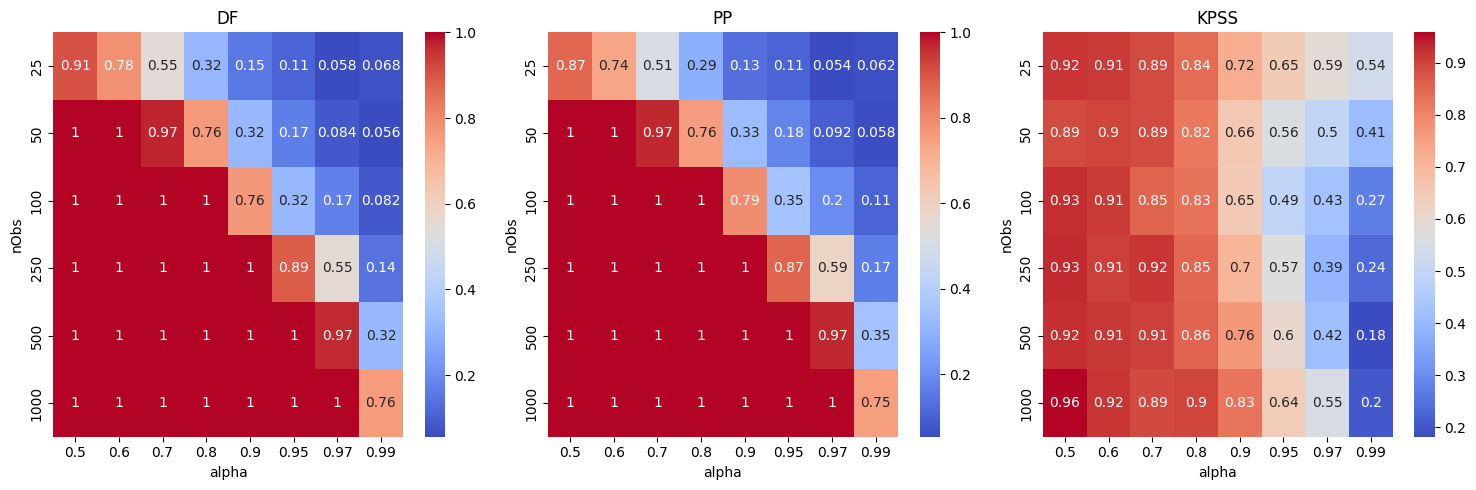

In [350]:
# Transforming data to tables appropriate for plotting heatmaps
df_pivot_DF = results_df.pivot(index="nObs", columns="alpha", values="DF")
df_pivot_PP = results_df.pivot(index="nObs", columns="alpha", values="PP")
df_pivot_KPSS = results_df.pivot(index="nObs", columns="alpha", values="KPSS")

# Here, we create the plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(df_pivot_DF, ax=axes[0], cmap="coolwarm", annot=True)
axes[0].set_title("DF")

sns.heatmap(df_pivot_PP, ax=axes[1], cmap="coolwarm", annot=True)
axes[1].set_title("PP")

sns.heatmap(df_pivot_KPSS, ax=axes[2], cmap="coolwarm", annot=True)
axes[2].set_title("KPSS")

plt.tight_layout()
plt.show()

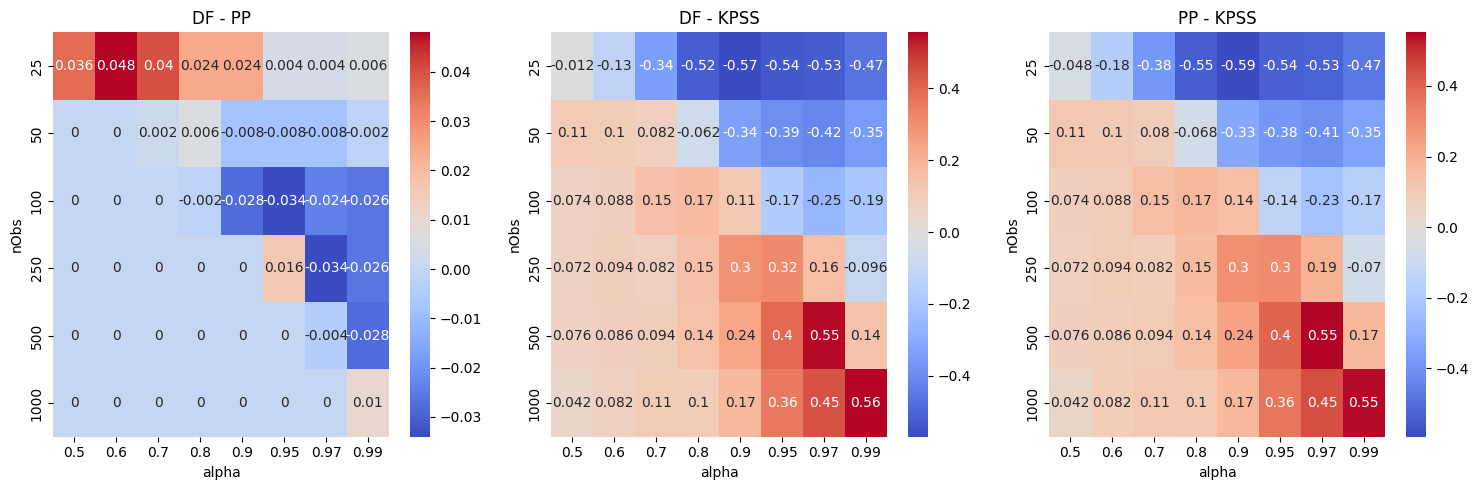

In [ ]:
# Calculating differences
results_df["DF_PP"] = results_df["DF"] - results_df["PP"]
results_df["DF_KPSS"] = results_df["DF"] - results_df["KPSS"]
results_df["PP_KPSS"] = results_df["PP"] - results_df["KPSS"]

# Transforming data to tables appropriate for plotting heatmaps
df_pivot_DF_PP = results_df.pivot(index="nObs", columns="alpha", values="DF_PP")
df_pivot_DF_KPSS = results_df.pivot(index="nObs", columns="alpha", values="DF_KPSS")
df_pivot_PP_KPSS = results_df.pivot(index="nObs", columns="alpha", values="PP_KPSS")

# Here, we create the plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(df_pivot_DF_PP, ax=axes[0], cmap="coolwarm", annot=True)
axes[0].set_title("DF - PP")

sns.heatmap(df_pivot_DF_KPSS, ax=axes[1], cmap="coolwarm", annot=True)
axes[1].set_title("DF - KPSS")

sns.heatmap(df_pivot_PP_KPSS, ax=axes[2], cmap="coolwarm", annot=True)
axes[2].set_title("PP - KPSS")

plt.tight_layout()
plt.show()

### Exercises

1. Import data from yahoo finance for a selected symbol. Plot the series and its differences. Test the sereis for its integration order. How many augmentations are needed to make ADF test interpretable? What are the conclusions? 

2. Test for integration order of the series downloaded from yahoo finance in ex. 1 with PP and KPSS test. Are the conclusions consistent?